<a id="top" style="float:left;" href="http://dynfluid.ensam.eu/"><img style="height:100px;" src="https://hpp.education/Lessons/omnes-docet-ubique.png"/></a>
<a style="float:right;" href="http://www.cnam.fr//"><img style="height:80px;" src="https://upload.wikimedia.org/wikipedia/commons/6/66/Logo_cnam.gif"/></a>
<center></center>

<center>
<h3 style="color:#888888;"> <i>--  Simulation numérique en mécanique des fluides  --</i> </h3>
<h1> TP RK </h1>
<h3> Stabilité des schémas de Runge-Kutta </h3>
<h4>  </h4>
<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# la librairie time nous sera utile pour calculer le temps d'execution des scripts
import time 
#Option pour afficher les figures dans le notebook et eviter le plt.show():
%matplotlib inline   

<h1>Introduction</h1>

Pour discrétiser les dérivées temporelles des équations aux dérivées partielles, le type de schémas le plus employé est l'algorithme de Runge-Kutta. Il est utilisé pour discrétiser les équations de la forme:

$$
\displaystyle{\dfrac{\partial \mathbf{U}}{\partial t}=F(\mathbf{U})}
$$

Cet algorithme se caractérise par son nombre de pas $p$ et consiste à décomposer un pas de temps en $p$ pas (ou sous-itération). Ainsi, <b>sous condition de linéarité de la fonction</b> $F$, un algorithme de Runge-Kutta à $p$ pas pourra s'écrire sous la forme:

$$
\displaystyle{\mathbf{U}^{n+1}=\mathbf{U}^{n}+\sum_{j=1}^{p}\gamma_{j}\Delta t^{j}F^{(j)}(\mathbf{U}^{n})}
$$

où $F^{(j)}$ représente les compositions multiples de la fonction $F$ comme: $F^{(2)}(\mathbf{U})=F(F(\mathbf{U}))$. Les coefficients $\gamma_{j}$ dépendent du nombre de sous-pas utilisés. Ils sont calculés par identification aux développements de Taylor pour les schémas standards et par minimisation des erreurs de dispersion et de dissipation pour les schémas optimisés. On donne dans le tableau suivant les coefficients de quelques schémas RK standarts:


<table>
<tr>
 <td>RK2</td> <td>1</td> <td>1/2</td> <td></td><td></td></tr>
 <tr><td>RK3</td> <td> 1</td> <td>1/2</td> <td>1/6</td> <td></td></tr>
 <tr><td>RK4</td> <td>1</td> <td>1/2</td> <td>1/6</td> <td>1/24</td> </tr>
</table>
<center><i>Coefficient $\gamma_j$ de quelques schémas RK. </i></center>



<h1>Annalyse de von Neumann</h1>

 <h2>Cas général</h2>

Afin d'étudier les conditions de stabilité des schémas de Runge-Kutta, on applique l'analyse de von-Neumann étudiée en cours en suposant une forme harmonique des inconnues $U^{n}$. De plus, la fonction $F$ étant suposée linéaire, on pourra écrire: $F(U^n)=A.U^n$ avec $A$ un opérateur dépendant de l'équation à résoudre et du schéma spatial utilisé. De fait, on a alors:

$$
\displaystyle{F^{(j)}(\mathbf{U}^{n})=A^j U^n}
$$

et l'équation devient:

$$
\displaystyle{\mathbf{U}^{n+1}=\left[1+\sum_{j=1}^{p}\gamma_{j}\Delta t^{j} A^{j}\right]\mathbf{U}^{n}}
$$

Ainsi, on peut exprimer le module du taux d'amplification des instabilités $\epsilon=\mathbf{U}^{n+1}/\mathbf{U}^{n}$ sous la forme:

$$
\displaystyle{R=|\epsilon|=\left| 1+\sum_{j=1}^{p}\gamma_{j}\Delta t^{j} A^{j}\right|}
$$

De façon générale, on considère souvent l'opérateur $A$ sous forme complexe et on note $\Delta t^{j} A^{j}=z^j$. On peut alors représenter la condition $R<1$ dans le plan complexe :



(-3, 1)

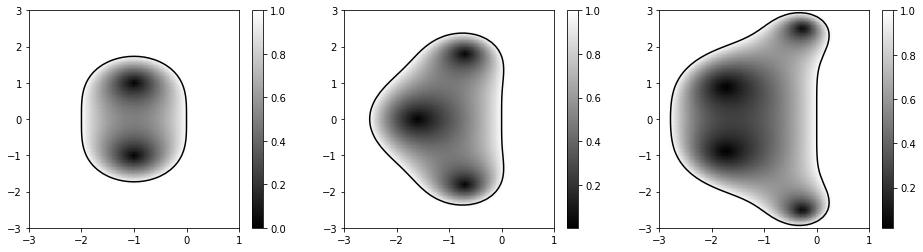

In [4]:
x=np.arange(-3.,3.1,0.1)
y=np.arange(-3.,3.1,0.1)
X,Y=np.meshgrid(x,y)
z=X+1j*Y

R2=abs(1.+z+0.5*z*z)
R3=abs(1.+z+0.5*z*z+z**3/6.)
R4=abs(1.+z+0.5*z*z+z**3/6.+z**4/24.)

fig=plt.figure(figsize=(16,4))
fig.add_subplot(131)
plt.pcolormesh(x,y,R2,vmax=1.,cmap='gray',shading='gouraud')
plt.colorbar();plt.contour(x,y,R2,[0,1.],colors='k');plt.xlim(-3,1)
fig.add_subplot(132)
plt.pcolormesh(x,y,R3,vmax=1.,cmap='gray',shading='gouraud')
plt.colorbar();plt.contour(x,y,R3,[0,1.],colors='k');plt.xlim(-3,1)
fig.add_subplot(133)
plt.pcolormesh(x,y,R4,vmax=1.,cmap='gray',shading='gouraud')
plt.colorbar();plt.contour(x,y,R4,[0,1.],colors='k');plt.xlim(-3,1)

<h2>Application à l'équation de transport</h2>

On souhaite ici étudier les conditions de stabilité d'un schéma Runge-Kutta pour résoudre l'équation de transport 1D:
$$
\displaystyle{\dfrac{\partial \mathbf{U}}{\partial t}=-c\dfrac{\partial \mathbf{U}}{\partial x}}
$$

On utilisera les différences finies d'ordre 1 classiques (centrées ou décentrées) pour la discrétisation de l'espace. Ce choix est certe un peu saugrenue car associer une ordre 1 en espace à un ordre 4 en temps peut paraître surprenant, cependant cela convient mieux à la clarté des développements exposés. (le lecteur avisé pourra bien entendu appliquer cette méthode pour des discrétisations d'ordre plus élevé).

Ainsi, l'opérateur de dérivation spatiale $A$ s'écrit respectivement pour le schéma centré, décentré amont et décentré aval:

$$
\left \{
\begin{array}{rcl}
A_{cent} & = & \dfrac{-cI}{\Delta x}sin(k\Delta x) \\ 
 A_{up} &=&\dfrac{-c}{\Delta x}(e^{Ik\Delta x}-1)\\
A_{down}&=& \dfrac{-c}{\Delta x}(1-e^{-Ik\Delta x})
\end{array}
\right .
$$

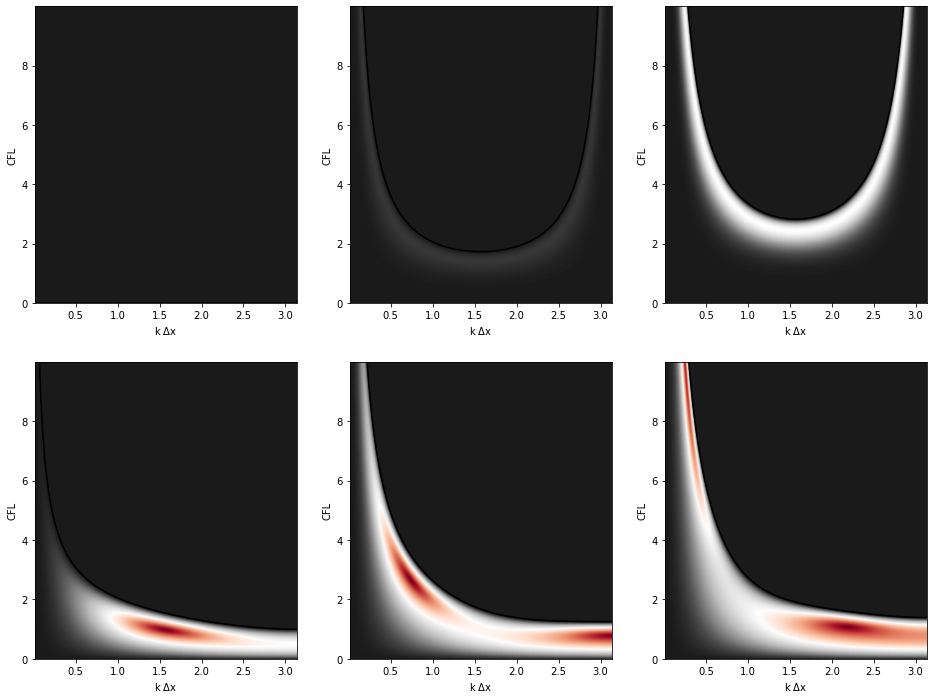

In [10]:
k=np.arange(0.01,np.pi,0.01)
CFL=np.arange(0.,10.,0.01)
Ac=np.einsum('i,j->ij',-CFL*1j,np.sin(k))
Ad=np.einsum('i,j->ij',-CFL,1-np.exp(-1j*k))

def plot_R(k,C,R):
    plt.pcolormesh(k,CFL,R,cmap='RdGy',shading='gouraud',vmin=0,vmax=1.);
    plt.xlabel('k $\Delta$x');plt.ylabel('CFL')
    plt.contour(k,CFL,R,[0,1.],colors='k')

R11=abs(1.+Ac+Ac**2/2.)
R12=abs(1.+Ac+Ac**2/2.+Ac**3/6.)
R13=abs(1.+Ac+Ac**2/2.+Ac**3/6.+Ac**4/24.)
R21=abs(1.+Ad+Ad**2/2.)
R22=abs(1.+Ad+Ad**2/2.+Ad**3/6.)
R23=abs(1.+Ad+Ad**2/2.+Ad**3/6.+Ad**4/24.)

fig=plt.figure(figsize=(16,12))
fig.add_subplot(2,3,1);plot_R(k,CFL,R11)
fig.add_subplot(2,3,2);plot_R(k,CFL,R12)
fig.add_subplot(2,3,3);plot_R(k,CFL,R13)
fig.add_subplot(2,3,4);plot_R(k,CFL,R21)
fig.add_subplot(2,3,5);plot_R(k,CFL,R22)
fig.add_subplot(2,3,6);plot_R(k,CFL,R23)

On observe une zone de stabilité plus complexe que les schémas à 1 pas. En effet, les zones d'instabilité dépendent à la fois du CFL mais également du nombre de point par longueur d'onde $N_{ppw}=\dfrac{2\pi}{k\Delta x}$

Text(0, 0.5, '$|G|$')

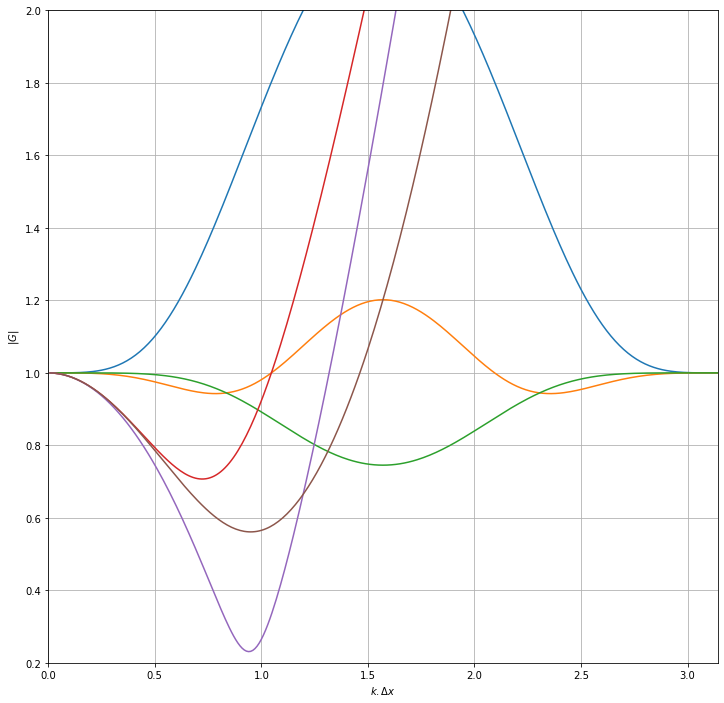

In [11]:
ind=np.where(CFL==2.0)[0][0];
fig=plt.figure(figsize=(12,12))
plt.plot(k,R11[ind,:]);plt.plot(k,R12[ind,:]);plt.plot(k,R13[ind,:])
plt.plot(k,R21[ind,:]);plt.plot(k,R22[ind,:]);plt.plot(k,R23[ind,:])
plt.xlim(0.,np.pi);plt.grid();plt.ylim(0.2,2);plt.xlabel('$k.\Delta x$');plt.ylabel('$|G|$')

# Conclusion

Présentez une synthèse de vos résultats et des étapes de calcul de votre TP.

In [1]:
from IPython.core.display import HTML
style=open('notebooks.css', "r").read()
HTML(style)

$$
\left[
 \begin{array}{ccc}
  1 & 0 & 0 \\
  0 & \ddots & 0 \\
  0 & 0 & 1 \\
 \end{array}
\right]
$$

<a id="top" style="float:left;" href="http://dynfluid.ensam.eu/"><img style="height:100px;" src="https://hpp.education/Lessons/omnes-docet-ubique.png"/></a>
<a style="float:right;" href="http://www.cnam.fr//"><img style="height:80px;" src="https://upload.wikimedia.org/wikipedia/commons/6/66/Logo_cnam.gif"/></a>
<center><a href="#top">Retour en haut de la page</a></center>